# Tomato Disease Detection
Disease detection using transfer learning, and dataset balancing

In [1]:
!pip install opendatasets

  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=94e56a26cf756d30dd3f12d763a9640d1fe88995d93c2f0cde97e185d0ba1721
  Stored in directory: c:\users\minorva\appdata\local\pip\cache\wheels\ac\b2\c3\fa4706d469b5879105991d1c8be9a3c2ef329ba9fe2ce5085e
Successfully built kaggle


In [1]:
import opendatasets as od

# Alternative
# od.download("https://www.kaggle.com/datasets/charuchaudhry/plantvillage-tomato-leaf-dataset")
od.download("https://www.kaggle.com/datasets/emmarex/plantdisease")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: aureliusryowang
Your Kaggle Key: ········


100%|███████████████████████████████████████████████████████████████████████████████| 658M/658M [02:23<00:00, 4.79MB/s]


### Removing Unecessary Data
Only take 🍅 data

In [3]:
import shutil

# Only take Tomato Dataset
try:
    shutil.rmtree('./plantdisease/plantvillage/')
    shutil.rmtree('./plantdisease/PlantVillage/Pepper__bell___Bacterial_spot')
    shutil.rmtree('./plantdisease/PlantVillage/Pepper__bell___healthy')
    shutil.rmtree('./plantdisease/PlantVillage/Potato___Early_blight')
    shutil.rmtree('./plantdisease/PlantVillage/Potato___Late_blight')
    shutil.rmtree('./plantdisease/PlantVillage/Potato___healthy')

except:
    print('Cannot find directory')

Cannot find directory


### Delete Augmented Data that used for Balancing

In [191]:
import shutil

try:
    shutil.rmtree('./aug')
except:
    print('Cannot find directory')

### Preview Image

In [192]:
import os

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import numpy as np
import pandas as pd

(256, 256, 3)


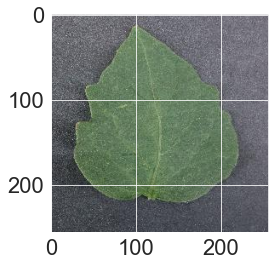

In [193]:
fpath = r'./plant-village-dataset/Tomato___healthy/000146ff-92a4-4db6-90ad-8fce2ae4fddd___GH_HL Leaf 259.1.JPG'
img = plt.imread(fpath)

print(img.shape)
imshow(img)

## Creating Pandas for Classes

In [194]:
source_dir = r'./plant-village-dataset'
subdir = os.listdir(source_dir)    

filepaths = []
labels = []    

for i in subdir:
    classpath = os.path.join(source_dir, i)

    if os.path.isdir(classpath):
        file_list = os.listdir(classpath)        
        for f in file_list:
            file_path = os.path.join(classpath, f)        
            filepaths.append(file_path)
            labels.append(i)

paths = pd.Series(filepaths, name='paths')
labels = pd.Series(labels, name='labels')    

df = pd.concat([paths, labels], axis=1)    

print(df.head())
print("========================")
print(df['labels'].value_counts())
print("========================")
print('Total data: ', len(df))

                                               paths                   labels
0  ./plant-village-dataset\Tomato___Bacterial_spo...  Tomato___Bacterial_spot
1  ./plant-village-dataset\Tomato___Bacterial_spo...  Tomato___Bacterial_spot
2  ./plant-village-dataset\Tomato___Bacterial_spo...  Tomato___Bacterial_spot
3  ./plant-village-dataset\Tomato___Bacterial_spo...  Tomato___Bacterial_spot
4  ./plant-village-dataset\Tomato___Bacterial_spo...  Tomato___Bacterial_spot
unknown                                          50000
Tomato___Tomato_Yellow_Leaf_Curl_Virus            5357
Tomato___Bacterial_spot                           2127
Tomato___Late_blight                              1909
Tomato___Septoria_leaf_spot                       1771
Tomato___Spider_mites Two-spotted_spider_mite     1676
Tomato___healthy                                  1591
Tomato___Target_Spot                              1404
Tomato___Early_blight                             1000
Tomato___Leaf_Mold                   

## Balancing Dataset
We will be cutting dataset into 700 image per class

In [195]:
sample_list = []
max_size = 700 # TODO: Change this value

grouping = df.groupby('labels')

for label in df['labels'].unique():
    group = grouping.get_group(label)
    group_size = len(group)

    if group_size > max_size:
        samples = group.sample(max_size, replace=False, weights=None, axis=0).reset_index(drop=True)
    else:
        samples = group.sample(frac=1.0, replace=False, axis=0).reset_index(drop=True)
    sample_list.append(samples)

df = pd.concat(sample_list, axis=0).reset_index(drop=True)
print(df['labels'].value_counts())
print('Total data: ', len(df))     

Tomato___Bacterial_spot                          700
Tomato___Early_blight                            700
Tomato___healthy                                 700
Tomato___Late_blight                             700
Tomato___Leaf_Mold                               700
Tomato___Septoria_leaf_spot                      700
Tomato___Spider_mites Two-spotted_spider_mite    700
Tomato___Target_Spot                             700
Tomato___Tomato_Yellow_Leaf_Curl_Virus           700
unknown                                          700
Tomato___Tomato_mosaic_virus                     373
Name: labels, dtype: int64
Total data:  7373


### Creating Augmented Dataset

We will be using augmented dataset to balanced the data

In [196]:
import os
import shutil
from keras.preprocessing.image import ImageDataGenerator

In [197]:
working_dir = r'./'
aug_dir = os.path.join(working_dir, 'aug')
if os.path.isdir(aug_dir):
    shutil.rmtree(aug_dir)
os.mkdir(aug_dir)
for label in df['labels'].unique():
    dir_path=os.path.join(aug_dir,label)    
    os.mkdir(dir_path)
print(os.listdir(aug_dir))

['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'unknown']


In [198]:
target = 700 # set the target count for each class in df
gen = ImageDataGenerator(
  rotation_range=90, 
  horizontal_flip=True, 
  vertical_flip=True,
)

grouping = df.groupby('labels') # group by class

for label in df['labels'].unique():  # for every class               
    group = grouping.get_group(label)  # a dataframe holding only rows with the specified label 
    sample_count = len(group)   # determine how many samples there are in this class  
    if sample_count < target: # if the class has less than target number of images
        aug_img_count = 0

        delta = target - sample_count  # number of augmented images to create
        target_dir = os.path.join(aug_dir, label)  # define where to write the images    

        aug_gen = gen.flow_from_dataframe(
            group, 
            x_col='paths', 
            y_col=None, 
            target_size=(224,224), # change this target size based on transfer learning model
            class_mode=None,
            batch_size=1, 
            shuffle=False, 
            save_to_dir=target_dir, 
            save_prefix='aug-',
            save_format='jpg'
        )

        while aug_img_count < delta:
            images = next(aug_gen)            
            aug_img_count += len(images) 

Found 373 validated image filenames.


In [199]:
aug = r'./aug'
auglist = os.listdir(aug)
for class_name in auglist:
    classpath = os.path.join(aug, class_name)
    file_list = os.listdir(classpath)
    print('class:', class_name, 'file count:', len(file_list))

class: Tomato___Bacterial_spot file count: 0
class: Tomato___Early_blight file count: 0
class: Tomato___healthy file count: 0
class: Tomato___Late_blight file count: 0
class: Tomato___Leaf_Mold file count: 0
class: Tomato___Septoria_leaf_spot file count: 0
class: Tomato___Spider_mites Two-spotted_spider_mite file count: 0
class: Tomato___Target_Spot file count: 0
class: Tomato___Tomato_mosaic_virus file count: 327
class: Tomato___Tomato_Yellow_Leaf_Curl_Virus file count: 0
class: unknown file count: 0


### Preview Augmented Data

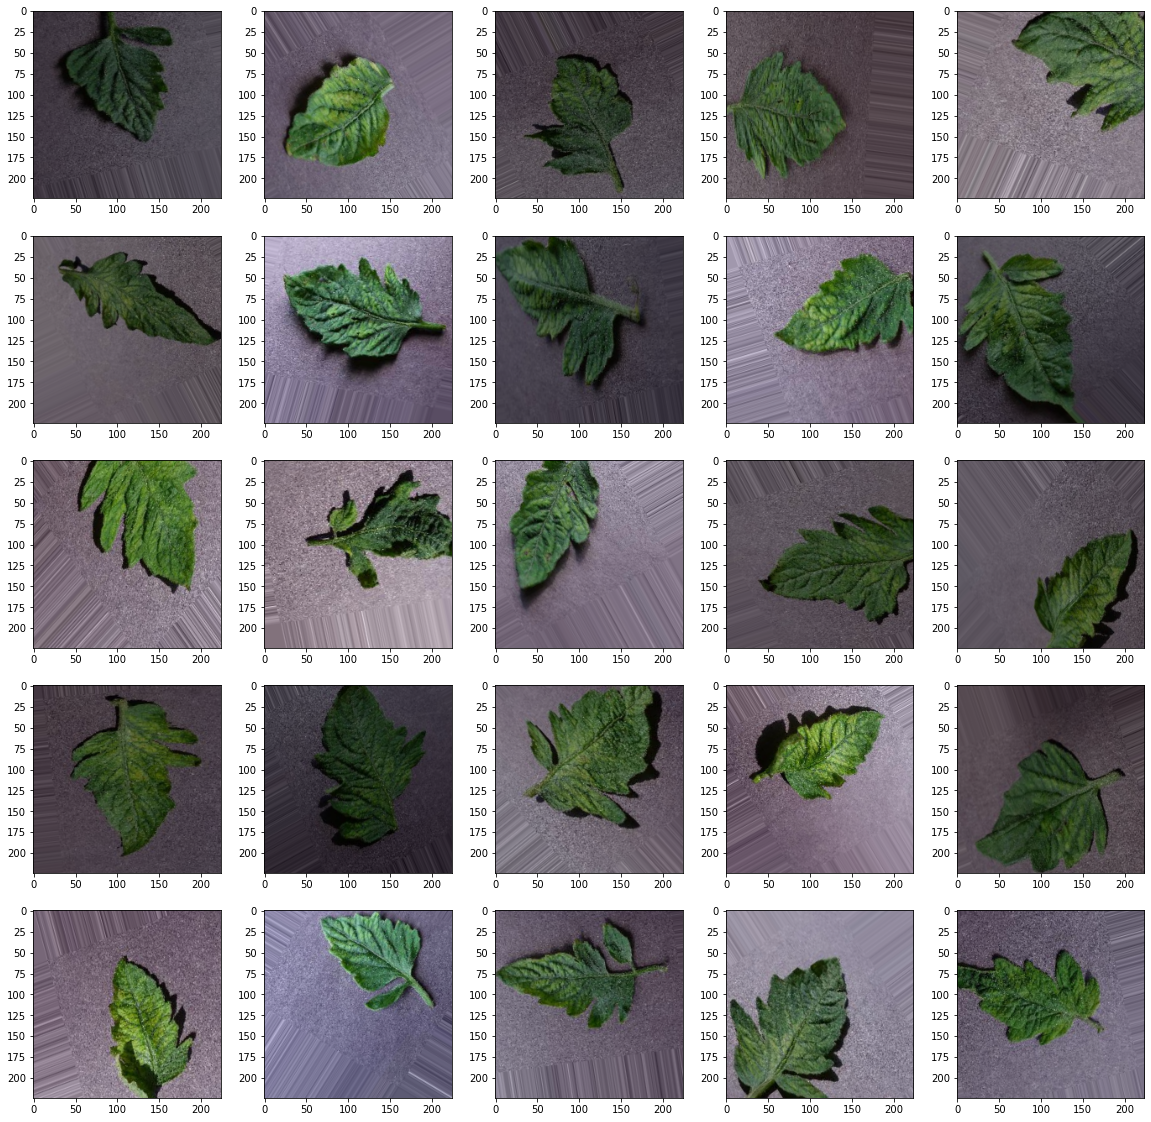

In [28]:
plt.figure(figsize=(20, 20))
for i in range(25):
    image = next(aug_gen) / 255
    image = np.squeeze(image, axis=0)
    plt.subplot(5, 5, i+1)
    plt.imshow(image)
    
plt.show()

In [200]:
aug_fpaths = []
aug_labels = []

classlist = os.listdir(aug_dir)

for class_names in classlist:
    classpath = os.path.join(aug_dir, class_names)     
    flist = os.listdir(classpath)    
    for f in flist:        
        fpath=os.path.join(classpath,f)         
        aug_fpaths.append(fpath)
        aug_labels.append(class_names)

Fseries = pd.Series(aug_fpaths, name='paths')
Lseries = pd.Series(aug_labels, name='labels')

aug_df = pd.concat([Fseries, Lseries], axis=1)

ndf = pd.concat([df,aug_df], axis=0).reset_index(drop=True)

print(df['labels'].value_counts()) 
print("=============================")
print(aug_df['labels'].value_counts())
print("=============================")
print(ndf['labels'].value_counts()) 

Tomato___Bacterial_spot                          700
Tomato___Early_blight                            700
Tomato___healthy                                 700
Tomato___Late_blight                             700
Tomato___Leaf_Mold                               700
Tomato___Septoria_leaf_spot                      700
Tomato___Spider_mites Two-spotted_spider_mite    700
Tomato___Target_Spot                             700
Tomato___Tomato_Yellow_Leaf_Curl_Virus           700
unknown                                          700
Tomato___Tomato_mosaic_virus                     373
Name: labels, dtype: int64
Tomato___Tomato_mosaic_virus    327
Name: labels, dtype: int64
Tomato___Bacterial_spot                          700
Tomato___Early_blight                            700
Tomato___healthy                                 700
Tomato___Late_blight                             700
Tomato___Leaf_Mold                               700
Tomato___Septoria_leaf_spot                      700
Tomato___

# Model Training
**Model Parameters:**

Image Size: `256x256`

Image Type: `Color`

Batch Size: `16`

Validation Split: `80/20` (`80/(10/10))`, `70/30`, `50-50` (use preferably)

Transfer Learning Model: `EfficientNet`

For more model reference, check [this](https://keras.io/api/applications/)

In [201]:
# !pip install livelossplot

In [202]:
import os
from keras.models import Model
from keras.applications.efficientnet import EfficientNetB0, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from pathlib import Path
import numpy as np

import tensorflow as tf

# from livelossplot import PlotLossesKeras

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

## Presets
Preset for model

In [245]:
EPOCHS = 30
BATCH_SIZE = 32

# Patience for reducing learning rate
PATIENCE = EPOCHS//5
LR_FACTOR = 0.2
WEIGHTS_FILE = "weights.h5" #File that stores updated weights

ORI_IMG_SIZE = 256

# IMG size for preprocessing
# Refer https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
IMG_SIZE = 224 

In [204]:
CLASS_NAMES = [
    'Tomato Bacterial Spot',
    'Tomato Early Blight',
    'Tomato Late Blight',
    'Tomato Leaf Mold',
    'Tomato Septoria Leaf Spot',
    'Tomato Spider Mites',
    'Tomato Target_Spot',
    'Tomato Yellow Leaf Curl Virus',
    'Tomato Tomato Mosaic Virus',
    'Tomato Healthy',
    'Unknown'
]

## Splitting Dataset 
**optional*\
Splitting dataset into train and validation and test set using sklearn

In [205]:
train_split = 0.8
valid_split = 0.1
dummy_split = valid_split / (1 - train_split)

train_df, dummy_df = train_test_split(ndf, train_size=train_split, shuffle=True, random_state=123)
valid_df, test_df = train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)

print ('train_df length:', len(train_df),'| test_df length:', len(test_df), '| valid_df length:', len(valid_df))

train_df length: 6160 | test_df length: 770 | valid_df length: 770


## Preprocessing + Augmentation + Splitting

In [206]:
def createTrainAndValidation():
    # PREPROCESSING LIST:

    # Rescaling
    # Random rotation up to 90 degree
    # Random brightness for bright environment
    # Flip image horizontally and vertically
    # Random image shearing
    # Width and Height shifting
    # Zoom

    datagen = ImageDataGenerator(
        rotation_range=90, 
        brightness_range=[0.4, 1],
        horizontal_flip=True, 
        vertical_flip=True,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        shear_range=0.4,
        zoom_range = 0.15,
        fill_mode="nearest",
        preprocessing_function=preprocess_input
    )
    # datagen = ImageDataGenerator(
    #   preprocessing_function=preprocess_input
    # )

    test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

    train_data = datagen.flow_from_dataframe( 
        train_df, 
        x_col='paths', 
        y_col='labels', 
        target_size=(IMG_SIZE, IMG_SIZE), 
        class_mode='categorical',
        color_mode='rgb', 
        shuffle=True, 
        batch_size=BATCH_SIZE
    )
    valid_data = test_generator.flow_from_dataframe(
        valid_df, 
        x_col='paths', 
        y_col='labels', 
        target_size=(IMG_SIZE, IMG_SIZE), 
        class_mode='categorical',
        color_mode='rgb',
        shuffle=True, 
        batch_size=BATCH_SIZE
    )

    test_data = test_generator.flow_from_dataframe(
      test_df, 
      x_col='paths', 
      y_col='labels', 
      target_size=(IMG_SIZE, IMG_SIZE), 
      class_mode='categorical',
      color_mode='rgb', 
      shuffle=False, 
    )

    return [train_data, valid_data, test_data]

## Callback Functions for Model

In [207]:
def assign_callbacks(weights_file,patience,lr_factor):
    return [
        # Saving weights that can be used
        # Only save the weights that correspond to the minimum validation loss.
        ModelCheckpoint(
            filepath=weights_file,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True ,
            save_weights_only=True,
            verbose=0
        ),
        # If val_loss doesn't improve for a number of epochs set with 'patience' 
        # variable, training will stop to avoid overfitting.    
        EarlyStopping(
            monitor='val_loss',
            mode='min',
            patience=patience,
            verbose=1
        ),
        # Learning rate is reduced by 'lr_factor' if val_loss stagnates
        # for a number of epochs set with 'patience/2' variable.
        ReduceLROnPlateau(
            monitor='val_loss',
            mode='min',
            factor=lr_factor,
            patience=patience//2,
            min_lr=1e-6,
            verbose=1
        ),
        # Livelossplot to show live preview plotting
        # *optional
        # PlotLossesKeras()
    ]

## Create Model

Creating model with these layers configuration:\
`GlobalAverangPooling2D` | `BatchNormalization` | `Dense` | `Dropout` | `Flatten`

In [262]:
# Create the whole neural network, pass the base model as parameter.
def create_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)

    # TODO: re-tune this parameter
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)

    predictions = Dense(11, activation='softmax')(x)
    model = Model(
        inputs=base_model.input, 
        outputs=predictions,
        name="Tomato_Disease"
    )

    # Freeze layers of the base model
    # prevents the weights in a given layer from being updated during training
    # for more info https://www.tensorflow.org/tutorials/images/transfer_learning#freeze_the_convolutional_base
    for layer in base_model.layers:
        layer.trainable = False

    # Add learning rate (default: 1e-3)
    # TODO: decrease this if loss does not decrease
    # decrease up to : 1e-4 / 1e-5 / 3e-5
    base_learning_rate = 1e-3
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
        loss='categorical_crossentropy',
        metrics='accuracy'
    )

    return model

In [263]:
train_data, valid_data, test_data = createTrainAndValidation()

# Define callbacks for training
callbacks = assign_callbacks(WEIGHTS_FILE,PATIENCE,LR_FACTOR)

Found 6160 validated image filenames belonging to 11 classes.
Found 770 validated image filenames belonging to 11 classes.
Found 770 validated image filenames belonging to 11 classes.


In [264]:
train_data.class_indices

{'Tomato___Bacterial_spot': 0,
 'Tomato___Early_blight': 1,
 'Tomato___Late_blight': 2,
 'Tomato___Leaf_Mold': 3,
 'Tomato___Septoria_leaf_spot': 4,
 'Tomato___Spider_mites Two-spotted_spider_mite': 5,
 'Tomato___Target_Spot': 6,
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 7,
 'Tomato___Tomato_mosaic_virus': 8,
 'Tomato___healthy': 9,
 'unknown': 10}

In [265]:
# Create the base pre-trained model
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE,IMG_SIZE,3)
)
#Create the complete new model.
model = create_model(base_model)

In [266]:
# Information about the model's layers.
model.summary()

Model: "Tomato_Disease"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_12 (Rescaling)       (None, 224, 224, 3)  0           ['input_13[0][0]']               
                                                                                                  
 normalization_12 (Normalizatio  (None, 224, 224, 3)  7          ['rescaling_12[0][0]']           
 n)                                                                                               
                                                                                     

                                                                                                  
 block2a_project_bn (BatchNorma  (None, 56, 56, 24)  96          ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, 56, 56, 144)  3456        ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 56, 56, 144)  576        ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block2b_expand_activation (Act  (None, 56, 56, 144)  0          ['block2b_expand_bn[0][0]']      
 ivation) 

 ization)                                                                                         
                                                                                                  
 block3b_expand_activation (Act  (None, 28, 28, 240)  0          ['block3b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, 28, 28, 240)  6000       ['block3b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3b_bn (BatchNormalization  (None, 28, 28, 240)  960        ['block3b_dwconv[0][0]']         
 )                                                                                                
          

                                                                                                  
 block4b_bn (BatchNormalization  (None, 14, 14, 480)  1920       ['block4b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4b_activation (Activation  (None, 14, 14, 480)  0          ['block4b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4b_s

 )                                                                                                
                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 480)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
                                                                                                  
 block5a_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block5a_se_reduce[0][0]']      
          

                                                                                                  
 block5c_se_excite (Multiply)   (None, 14, 14, 672)  0           ['block5c_activation[0][0]',     
                                                                  'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, 14, 14, 112)  75264       ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5c_drop (Dropout)         (None, 14, 14, 112)  0           ['block5c_project_bn[0][0]']     
          

 lization)                                                                                        
                                                                                                  
 block6b_drop (Dropout)         (None, 7, 7, 192)    0           ['block6b_project_bn[0][0]']     
                                                                                                  
 block6b_add (Add)              (None, 7, 7, 192)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6b_add[0][0]']            
                                                                                                  
 block6c_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block6c_expand_conv[0][0]']    
 ization) 

                                                                  'block6c_add[0][0]']            
                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6d_add[0][0]']            
                                                                                                  
 block7a_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 7, 7, 1152)  0           ['block7a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block7a_d

## Training Model

In [267]:
# Train the model on the dataset.
history=model.fit(
  x=train_data, 
  batch_size=BATCH_SIZE,
  epochs=EPOCHS, 
  verbose=1,
  validation_data=valid_data,
  callbacks=callbacks
) 

Epoch 1/30
193/193 [==============================] - 121s 612ms/step - loss: 1.1764 - accuracy: 0.6144 - val_loss: 0.9287 - val_accuracy: 0.7545 - lr: 0.0010
Epoch 2/30
193/193 [==============================] - 116s 599ms/step - loss: 0.6853 - accuracy: 0.7643 - val_loss: 0.5336 - val_accuracy: 0.8325 - lr: 0.0010
Epoch 3/30
193/193 [==============================] - 114s 589ms/step - loss: 0.5801 - accuracy: 0.8026 - val_loss: 0.4676 - val_accuracy: 0.8351 - lr: 0.0010
Epoch 4/30
193/193 [==============================] - 114s 591ms/step - loss: 0.5136 - accuracy: 0.8250 - val_loss: 0.4485 - val_accuracy: 0.8429 - lr: 0.0010
Epoch 5/30
193/193 [==============================] - 116s 599ms/step - loss: 0.4756 - accuracy: 0.8370 - val_loss: 0.3737 - val_accuracy: 0.8623 - lr: 0.0010
Epoch 6/30
193/193 [==============================] - 116s 599ms/step - loss: 0.4294 - accuracy: 0.8511 - val_loss: 0.3365 - val_accuracy: 0.8779 - lr: 0.0010
Epoch 7/30
193/193 [==========================

## Plotting Model

In [268]:
# Plot training learning curves for both train and validation.
def plot_training_curves(history):
        # Defining the metrics we will plot.
        train_acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        train_loss = history.history['loss']
        val_loss = history.history['val_loss']
        
        # Range for the X axis.
        epochs = range(len(train_loss))
        
        fig,axis = plt.subplots(1,2,figsize=(20,8)) # 1 row, 2 col, width = 20, height = 8 inches.

        # Plotting Loss figures.
        plt.rcParams.update({'font.size': 22}) #configuring font size.
        plt.subplot(1, 2, 1) #plot 1st curve.
        plt.plot(epochs, train_loss, c="red", label="Training Loss") #plotting
        plt.plot(epochs, val_loss, c="blue", label="Validation Loss")
        plt.xlabel("Epochs") #title for x axis
        plt.ylabel("Loss")   #title for y axis
        plt.legend()

        # Plotting Accuracy figures. 
        plt.subplot(1, 2, 2) # plot 2nd curve.
        plt.plot(epochs, train_acc, c="red", label="Training Acc") # plotting
        plt.plot(epochs, val_acc, c="blue", label="Validation Acc")
        plt.xlabel("Epochs")   # title for x axis
        plt.ylabel("Accuracy") # title for y axis
        plt.legend()

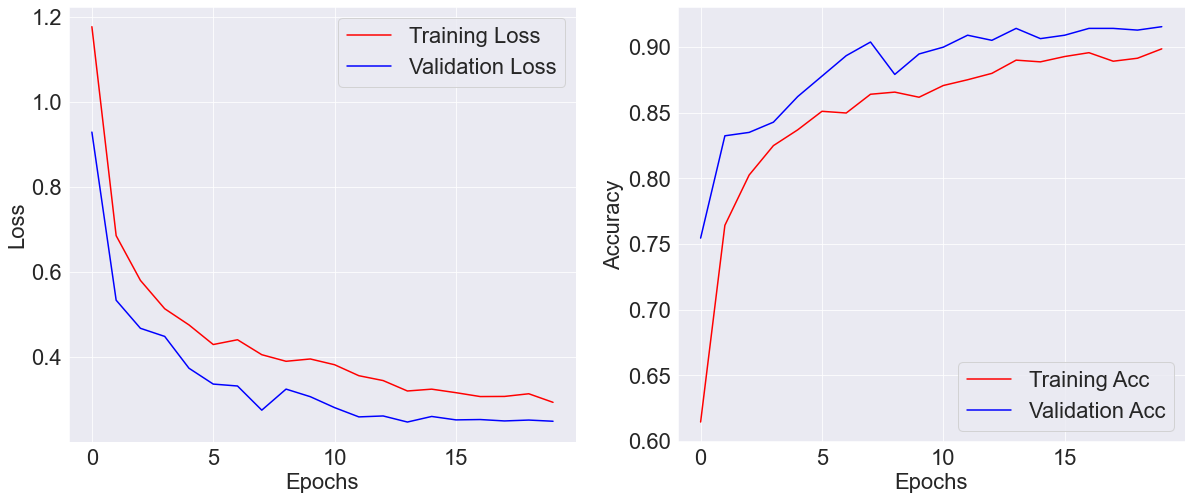

In [269]:
plot_training_curves(history)

## Evaluate Model

Evaluating model using `test_data`

In [270]:
model.evaluate(test_data)

25/25 [==============================] - 12s 497ms/step - loss: 0.2722 - accuracy: 0.9065


[0.27219459414482117, 0.9064934849739075]

## Saving Model to TFLite + Quantize Model

In [ ]:
# Load optimal weights computed during training.
model.load_weights(WEIGHTS_FILE)
# Convert the model to it's Tensorflow Lite equivalent
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT] # Quantized
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

## Saving model

In [271]:
import os
model_version = max([int(i) for i in os.listdir('./models') + [0]]) + 1
model.save(f"./models/{model_version}")

INFO:tensorflow:Assets written to: ./models/12\assets


## Testing Prediction for Each Class

In [272]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [ ]:
predictions = model.predict(test_data, verbose=1)
y_pred = np.argmax(predictions, axis=-1)

print(classification_report(test_data.classes, y_pred, target_names=CLASS_NAMES))
print(accuracy_score(test_data.classes, y_pred))

 4/25 [===>..........................] - ETA: 11s

In [ ]:
plt.figure(figsize=(30,30))
cm = confusion_matrix(test_data.classes, y_pred)
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, )
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()